# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

from vivace.backtest import (BacktestEngine, Strategy, Weighting, InstrumentDef,
                             Performance, signal, processing, rebase, PnLType)
from vivace.backtest.engine import long_only_returns

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy 1 ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

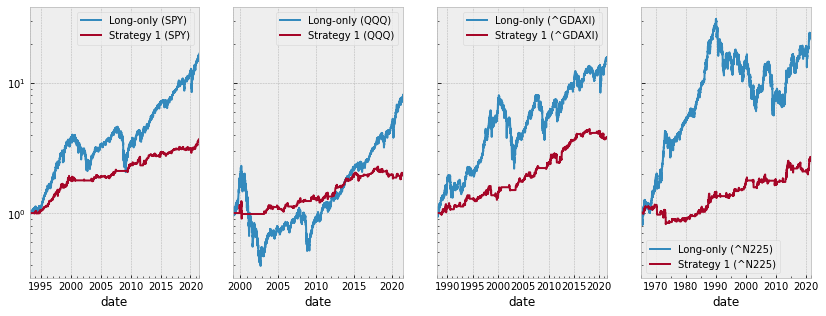

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112796,0.046814,0.127662,0.033796,0.103241,0.042006,0.072681,0.019066
CAGR,0.095703,0.044427,0.090453,0.029344,0.079162,0.038787,0.053442,0.016748
Annualised vol,0.184818,0.068977,0.273069,0.094624,0.219274,0.079949,0.195936,0.067639
Sharpe ratio,0.610311,0.678686,0.467510,0.357159,0.470830,0.525414,0.370940,0.281872
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.217462,0.818712,0.292850
Calmar ratio,0.204380,0.332590,0.153877,0.127061,0.142039,0.193166,0.088774,0.065104
Skewness,-0.050960,-1.133316,0.239225,1.685128,-0.130826,-1.965223,-0.199932,-4.109510
Kurtosis,12.647159,47.424309,7.505401,88.121669,6.835533,76.327156,9.726293,167.687339
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009


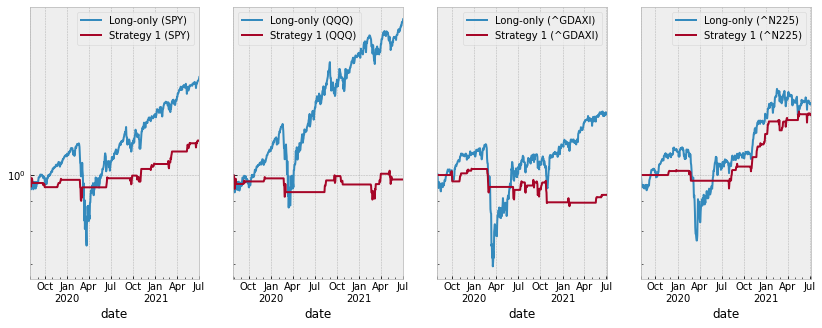

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

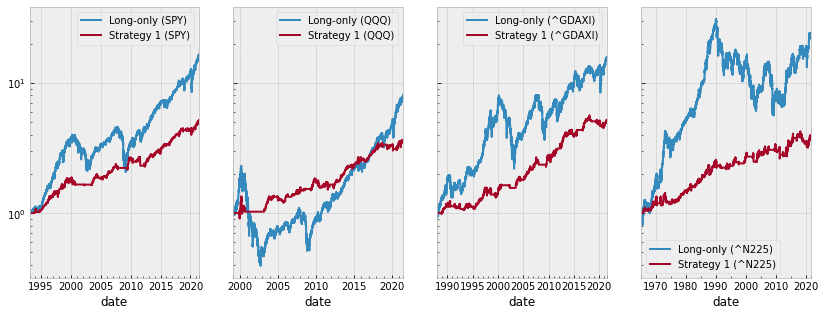

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112796,0.059260,0.127662,0.061071,0.103241,0.051405,0.072681,0.026996
CAGR,0.095703,0.056015,0.090453,0.054465,0.079162,0.047502,0.053442,0.023345
Annualised vol,0.184818,0.080453,0.273069,0.115088,0.219274,0.088344,0.195936,0.085017
Sharpe ratio,0.610311,0.736582,0.467510,0.530644,0.470830,0.581880,0.370940,0.317537
Max drawdown,0.551894,0.160132,0.829639,0.265982,0.726848,0.201483,0.818712,0.251076
Calmar ratio,0.204380,0.370071,0.153877,0.229606,0.142039,0.255135,0.088774,0.107521
Skewness,-0.050960,-0.779802,0.239225,0.702280,-0.130826,-0.076606,-0.199932,-2.542264
Kurtosis,12.647159,30.230855,7.505401,47.929297,6.835533,16.458470,9.726293,86.913339
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009


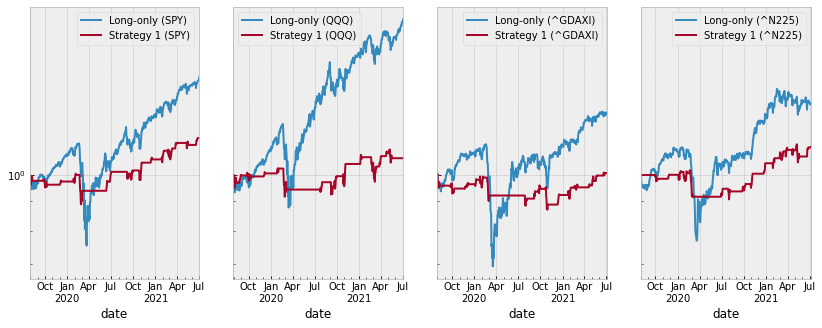

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

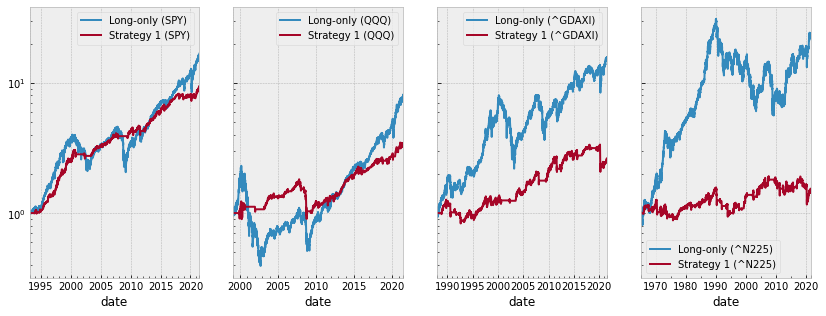

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112796,0.081043,0.127662,0.063102,0.103241,0.034609,0.072681,0.012645
CAGR,0.095703,0.076347,0.090453,0.052794,0.079162,0.027809,0.053442,0.007279
Annualised vol,0.184818,0.096856,0.273069,0.143797,0.219274,0.116212,0.195936,0.103174
Sharpe ratio,0.610311,0.836738,0.467510,0.438824,0.470830,0.297809,0.370940,0.122556
Max drawdown,0.551894,0.153225,0.829639,0.503464,0.726848,0.382193,0.818712,0.404694
Calmar ratio,0.204380,0.528914,0.153877,0.125335,0.142039,0.090554,0.088774,0.031245
Skewness,-0.050960,-0.311654,0.239225,0.674789,-0.130826,-1.254738,-0.199932,-1.644131
Kurtosis,12.647159,19.061302,7.505401,33.915631,6.835533,39.499406,9.726293,49.290673
Worst return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009


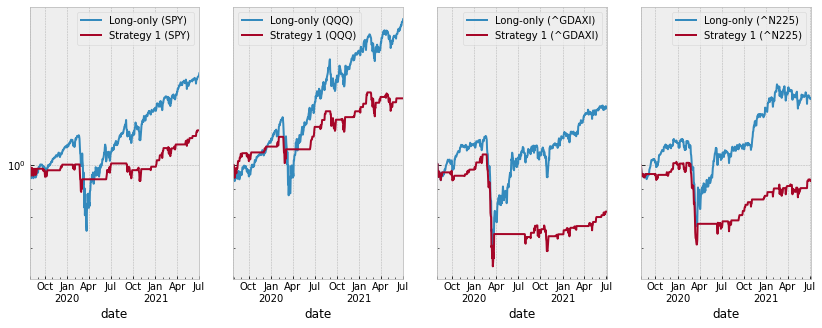

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

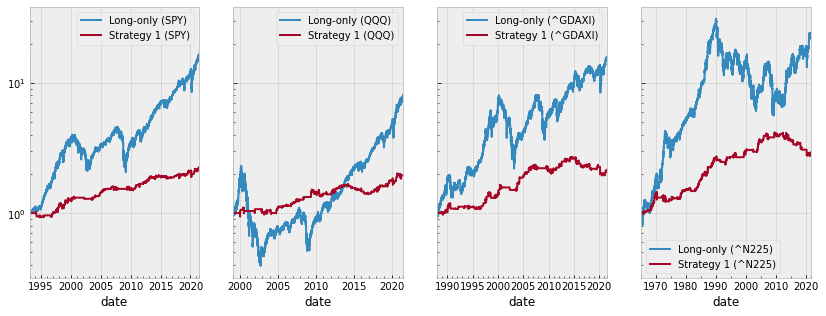

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112796,0.029509,0.127662,0.031825,0.103241,0.023920,0.072681,0.019425
CAGR,0.095703,0.027711,0.090453,0.028895,0.079162,0.021918,0.053442,0.018054
Annualised vol,0.184818,0.059888,0.273069,0.076481,0.219274,0.063264,0.195936,0.052224
Sharpe ratio,0.610311,0.492736,0.467510,0.416114,0.470830,0.378102,0.370940,0.371962
Max drawdown,0.551894,0.111611,0.829639,0.166739,0.726848,0.280084,0.818712,0.341473
Calmar ratio,0.204380,0.264390,0.153877,0.190866,0.142039,0.085404,0.088774,0.056887
Skewness,-0.050960,-0.851357,0.239225,-0.509557,-0.130826,-0.282494,-0.199932,-2.443048
Kurtosis,12.647159,54.065509,7.505401,32.868522,6.835533,29.267594,9.726293,105.363934
Worst return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856


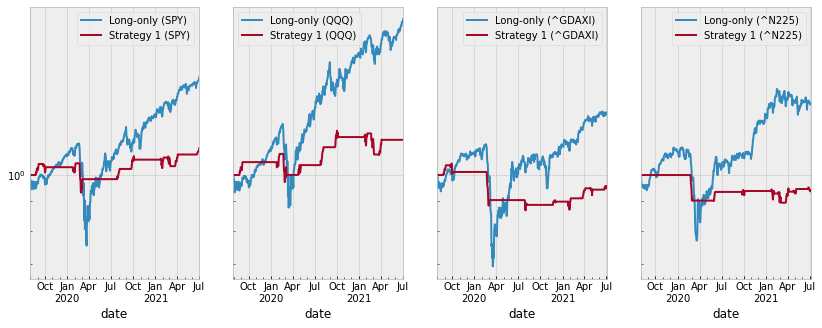

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 07-Jul-2021 06:58
